Setup

In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras
from keras import layers

2024-02-12 05:05:53.661772: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-12 05:05:53.663657: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-12 05:05:53.917266: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-12 05:05:54.784788: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-12 05:06:07.157865: W tensorflow/compiler/tf2

In [2]:
# Load dataset
root = "/lustre/home/debnathk/dleps/code/DLEPS/reference_drug/"
import h5py

h5f = h5py.File(root + 'ssp_data_train.h5', 'r')
ssp_train = h5f['data'][:]
h5f = h5py.File(root + 'ssp_data_test.h5', 'r')
ssp_test = h5f['data'][:]

print(ssp_train.shape)
print(ssp_test.shape)

(4000, 207, 3072)
(1000, 207, 3072)


(array([1.314e+03, 1.688e+03, 8.480e+02, 1.380e+02, 6.000e+00, 3.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([0.30925, 0.34085, 0.37245, 0.40405, 0.43565, 0.46725, 0.49885,
        0.53045, 0.56205, 0.59365, 0.62525]),
 <BarContainer object of 10 artists>)

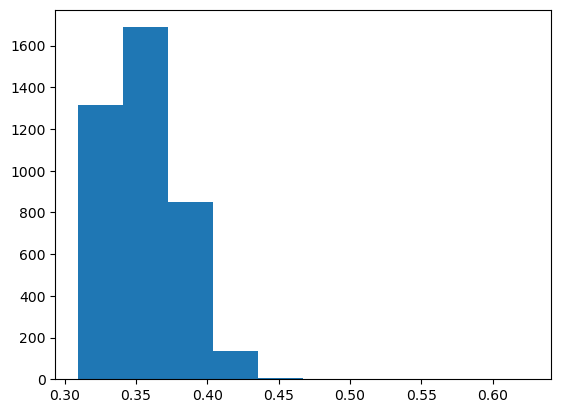

In [17]:
plt.hist(ssp_train[:, 100, :].sum(axis=1) / 4000)


Create a sampling layer

In [3]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

Build the encoder

In [4]:
latent_dim = 56

encoder_inputs = keras.Input(shape=(207, 3072))
# Add dense layer
x = layers.Conv1D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv1D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 207, 3072)]          0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 104, 32)              294944    ['input_1[0][0]']             
                                                                                                  
 conv1d_1 (Conv1D)           (None, 52, 64)               6208      ['conv1d[0][0]']              
                                                                                                  
 flatten (Flatten)           (None, 3328)                 0         ['conv1d_1[0][0]']            
                                                                                            

Build the decoder

In [5]:
# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(16, activation="relu")(latent_inputs)
x = layers.Reshape((1, 16))(x)
x = layers.Conv1DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv1DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
decoder_outputs = layers.Dense(207 * 3072, activation="sigmoid")(x)
decoder_outputs = layers.Reshape((207, 3072))(decoder_outputs)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 56)]              0         
                                                                 
 dense_1 (Dense)             (None, 16)                912       
                                                                 
 reshape (Reshape)           (None, 1, 16)             0         
                                                                 
 conv1d_transpose (Conv1DTr  (None, 2, 64)             3136      
 anspose)                                                        
                                                                 
 conv1d_transpose_1 (Conv1D  (None, 4, 32)             6176      
 Transpose)                                                      
                                                                 
 flatten_1 (Flatten)         (None, 128)               0   

Define the VAE as a Model with a custom train_step

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models

class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(data, reconstruction))
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# Instantiate the VAE model
vae = VAE(encoder=encoder, decoder=decoder)

# Compile the model
vae.compile(optimizer=tf.keras.optimizers.Adam())
num_epochs, batch_size = 100, 50


2024-02-12 05:07:42.806201: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 20348928000 exceeds 10% of free system memory.


Epoch 1/100
80/80 [==============================] - 52s 616ms/step - loss: 0.6544 - reconstruction_loss: 0.5973 - kl_loss: 6.6081e-04
Epoch 2/100
80/80 [==============================] - 49s 616ms/step - loss: 0.5258 - reconstruction_loss: 0.5275 - kl_loss: 9.8403e-05
Epoch 3/100
80/80 [==============================] - 49s 611ms/step - loss: 0.5294 - reconstruction_loss: 0.5265 - kl_loss: 3.9697e-05
Epoch 4/100
80/80 [==============================] - 48s 601ms/step - loss: 0.5242 - reconstruction_loss: 0.5251 - kl_loss: 2.9989e-05
Epoch 5/100
80/80 [==============================] - 48s 604ms/step - loss: 0.5236 - reconstruction_loss: 0.5245 - kl_loss: 1.8842e-05
Epoch 6/100
80/80 [==============================] - 48s 597ms/step - loss: 0.5200 - reconstruction_loss: 0.5231 - kl_loss: 1.3533e-05
Epoch 7/100
80/80 [==============================] - 46s 578ms/step - loss: 0.5257 - reconstruction_loss: 0.5232 - kl_loss: 9.0585e-06
Epoch 8/100
80/80 [==============================] - 47

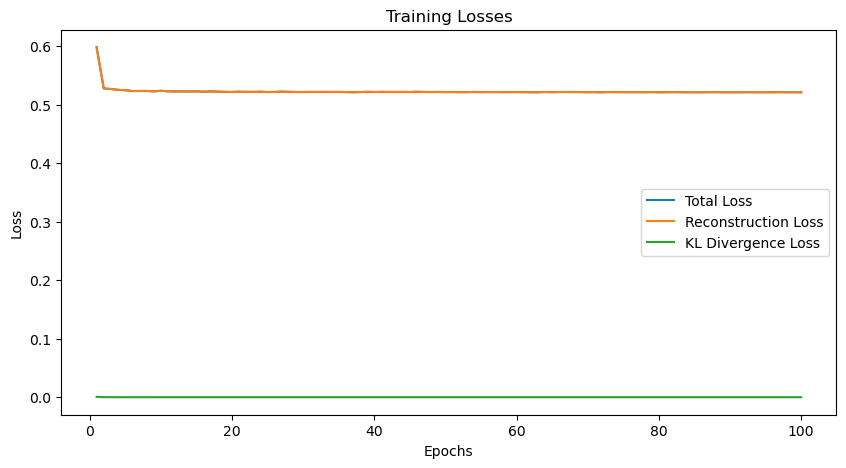

In [7]:
import matplotlib.pyplot as plt

# Assuming you've already trained the VAE using the code you provided

# Train the VAE model
history = vae.fit(ssp_train, epochs=num_epochs, batch_size=batch_size)

# Plot the losses over epochs
def plot_losses(history):
    loss = history.history['loss']
    reconstruction_loss = history.history['reconstruction_loss']
    kl_loss = history.history['kl_loss']

    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, loss, label='Total Loss')
    plt.plot(epochs, reconstruction_loss, label='Reconstruction Loss')
    plt.plot(epochs, kl_loss, label='KL Divergence Loss')

    plt.title('Training Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Plot the losses
plot_losses(history)

In [8]:
import keras
import tensorflow

keras.__version__
tensorflow.__version__

'2.15.0'